In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
BATCH_SIZE= 64
EPOCHS = 50
LATENT_DIM = 100

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5)) #-1부터 1사이의 값
    ]
)
datasets.MNIST(root='./data', train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:02<00:00, 3.99MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 141kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.33MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.86MB/s]


Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [4]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
#생성자
#100차원 노이즈를 입력받아 28X28X1로 출력
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(LATENT_DIM, 256 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (256, 7, 7)),


            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),


            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),


            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )


    def forward(self, z):
        img = self.model(z)
        return img 

In [11]:
generator = Generator().to(DEVICE)

In [12]:
generator

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=12544, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(256, 7, 7))
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

In [ ]:
#판별자
#28*28*1 크기를 입력받아 해당 이미지가 진짜일 확률을 구함
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64,128,kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Flatten(),
            nn.Linear(128*7*7,1)
            
            
        )
    def forward(self, img):
        validity = self.model(img)
        return validity

In [17]:
discriminator = Discriminator().to(DEVICE)

In [18]:
#손실함수 및 옵티마이저 정의 
# 손실함수
adversarial_loss = nn.BCEWithLogitsLoss()


# 옵티마이저
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [19]:
def view_images(epoch, generator, latent_dim, device):
    with torch.no_grad():
        z = torch.randn(16, latent_dim).to(device)
        generated = generator(z).cpu()


        fig, axes = plt.subplots(4,4, figsize=(4,4))
        for i, ax in enumerate(axes.flat):
            img = generated[i] * 0.5 + 0.5
            ax.imshow(img.squeeze(), cmap='gray')
            ax.axis('off')


        plt.savefig(f"image_at_epoch_{epoch:04d}.png")
        plt.show

[Epoch 0/50] [D loss: 0.1284] [G loss: 2.3658]
[Epoch 1/50] [D loss: 0.2636] [G loss: 1.6535]
[Epoch 2/50] [D loss: 0.3276] [G loss: 2.3573]
[Epoch 3/50] [D loss: 0.3547] [G loss: 2.7555]
[Epoch 4/50] [D loss: 0.2167] [G loss: 2.5703]
[Epoch 5/50] [D loss: 0.4338] [G loss: 1.4555]
[Epoch 6/50] [D loss: 0.4099] [G loss: 0.9344]
[Epoch 7/50] [D loss: 0.3133] [G loss: 1.3068]
[Epoch 8/50] [D loss: 0.5539] [G loss: 1.4921]
[Epoch 9/50] [D loss: 0.3152] [G loss: 1.1487]
[Epoch 10/50] [D loss: 0.3889] [G loss: 2.5971]
[Epoch 11/50] [D loss: 0.3647] [G loss: 1.8516]
[Epoch 12/50] [D loss: 0.4673] [G loss: 1.4093]
[Epoch 13/50] [D loss: 0.3096] [G loss: 2.0182]
[Epoch 14/50] [D loss: 0.7016] [G loss: 0.5447]
[Epoch 15/50] [D loss: 0.4239] [G loss: 1.9068]
[Epoch 16/50] [D loss: 0.5565] [G loss: 1.0722]
[Epoch 17/50] [D loss: 0.6729] [G loss: 0.5482]
[Epoch 18/50] [D loss: 0.4472] [G loss: 1.2605]
[Epoch 19/50] [D loss: 0.4664] [G loss: 1.8274]
[Epoch 20/50] [D loss: 0.3848] [G loss: 1.4035]


/tmp/ipykernel_6147/969660231.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(4,4, figsize=(4,4))


[Epoch 21/50] [D loss: 0.3708] [G loss: 2.6395]
[Epoch 22/50] [D loss: 0.4548] [G loss: 1.4621]
[Epoch 23/50] [D loss: 0.4020] [G loss: 1.6370]
[Epoch 24/50] [D loss: 0.5895] [G loss: 1.2769]
[Epoch 25/50] [D loss: 0.4065] [G loss: 1.2264]
[Epoch 26/50] [D loss: 0.3997] [G loss: 1.2672]
[Epoch 27/50] [D loss: 0.6370] [G loss: 0.7310]
[Epoch 28/50] [D loss: 0.6862] [G loss: 0.4905]
[Epoch 29/50] [D loss: 0.4400] [G loss: 1.5415]
[Epoch 30/50] [D loss: 0.3033] [G loss: 1.8877]
[Epoch 31/50] [D loss: 0.3943] [G loss: 1.8131]
[Epoch 32/50] [D loss: 0.4713] [G loss: 1.3932]
[Epoch 33/50] [D loss: 0.4860] [G loss: 1.6560]
[Epoch 34/50] [D loss: 0.6060] [G loss: 2.0096]
[Epoch 35/50] [D loss: 0.6152] [G loss: 2.1657]
[Epoch 36/50] [D loss: 0.3474] [G loss: 1.4966]
[Epoch 37/50] [D loss: 0.4143] [G loss: 1.1363]
[Epoch 38/50] [D loss: 0.5641] [G loss: 0.9173]
[Epoch 39/50] [D loss: 0.4782] [G loss: 1.1889]
[Epoch 40/50] [D loss: 0.4423] [G loss: 1.1924]
[Epoch 41/50] [D loss: 0.4520] [G loss: 

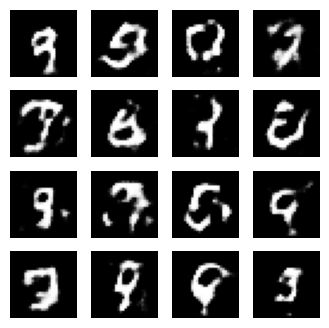

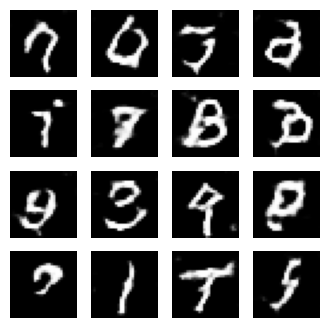

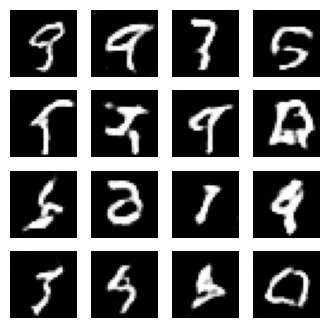

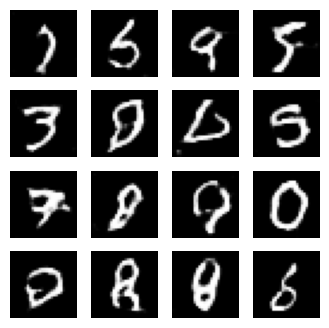

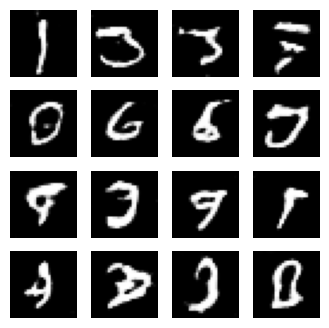

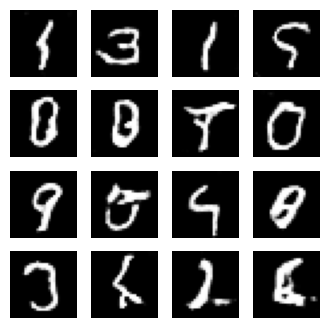

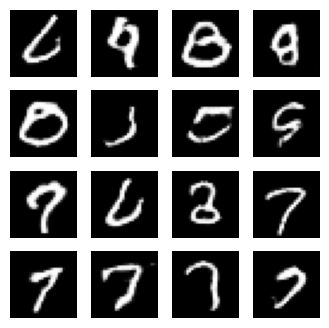

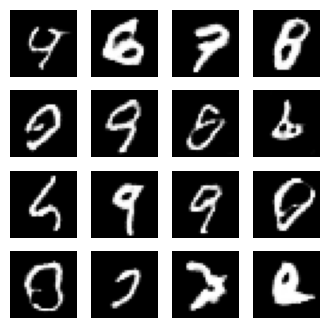

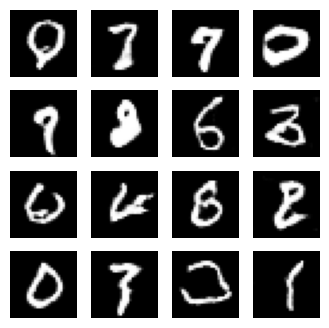

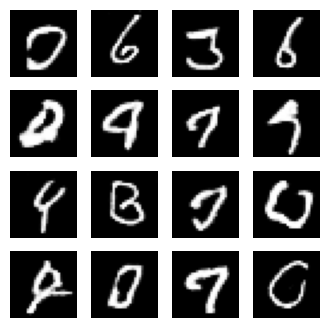

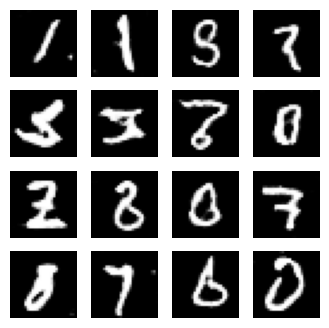

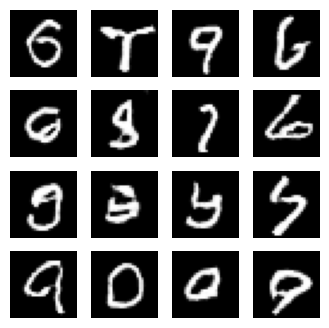

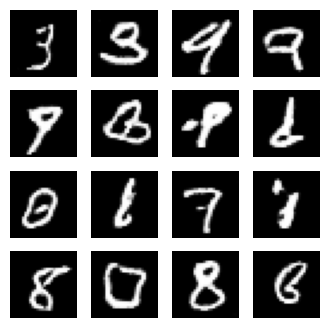

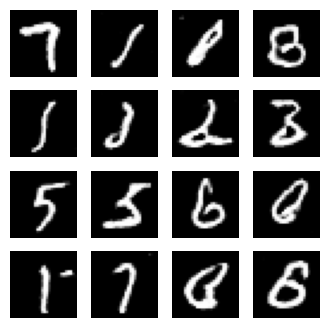

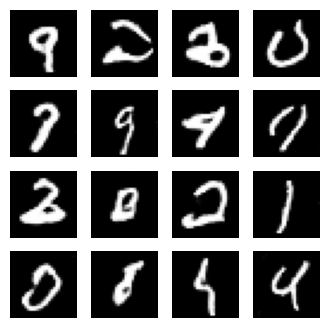

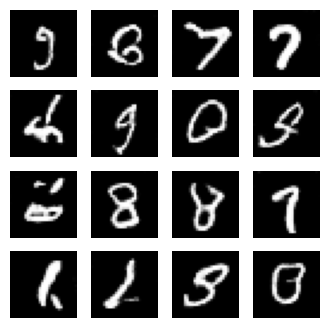

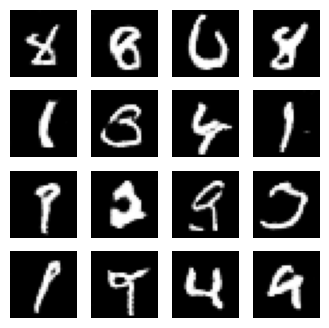

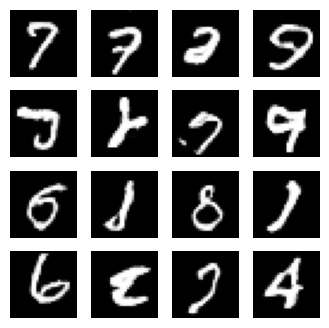

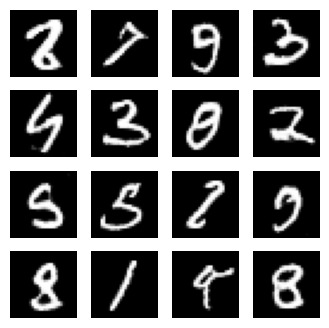

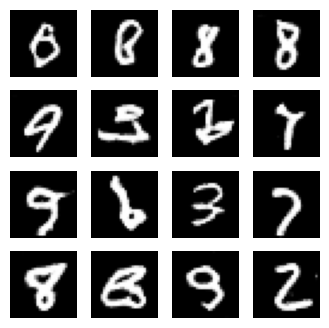

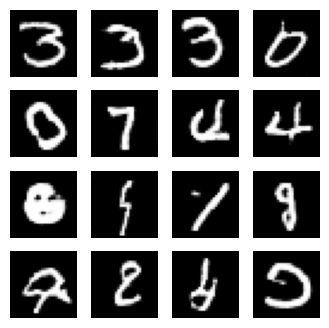

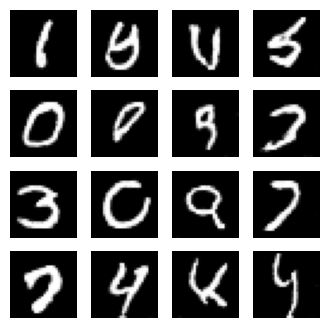

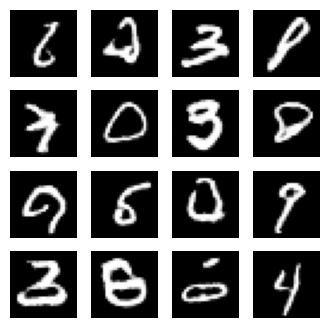

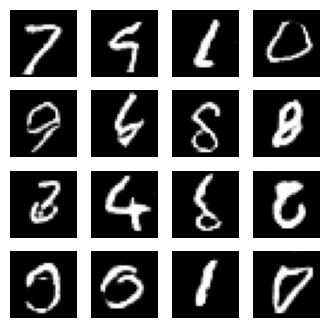

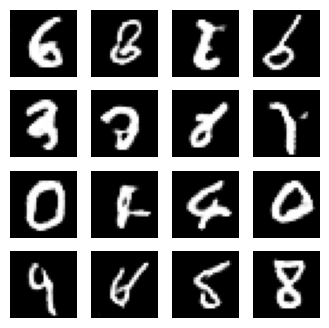

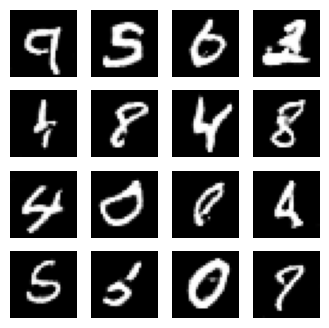

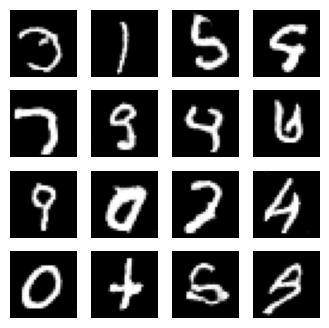

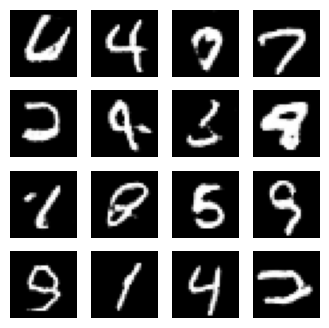

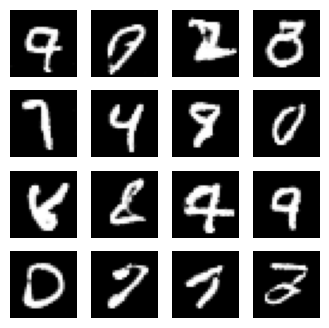

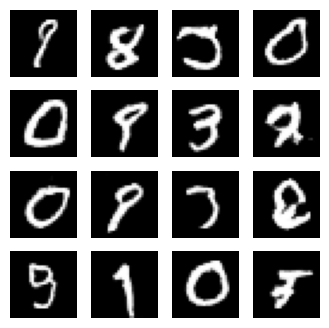

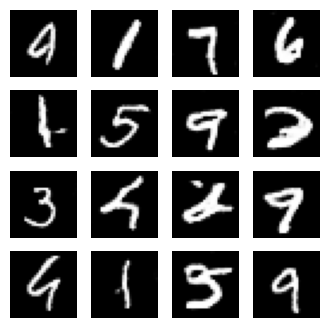

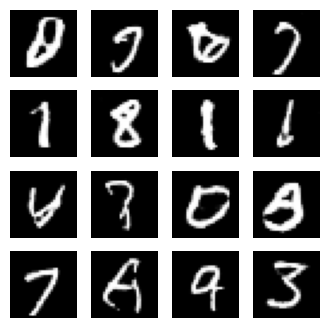

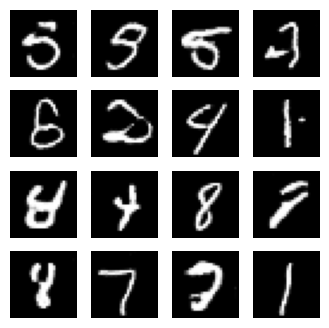

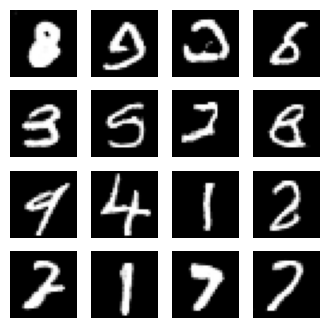

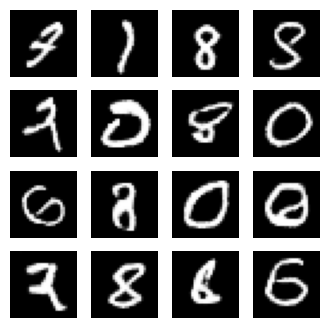

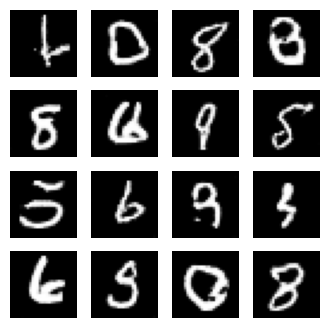

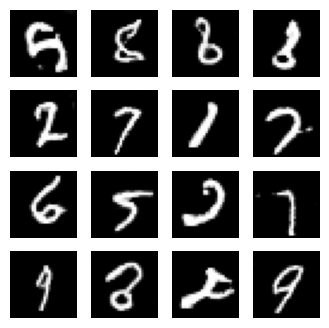

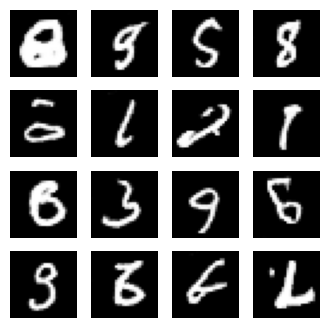

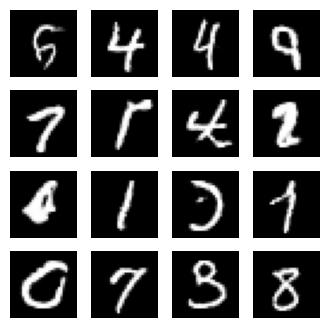

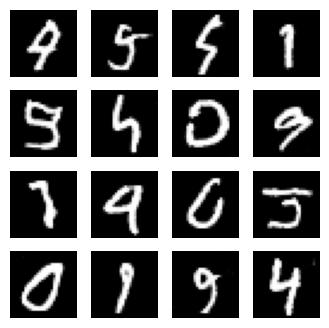

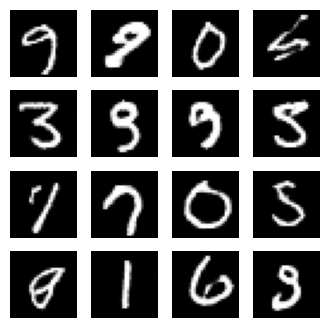

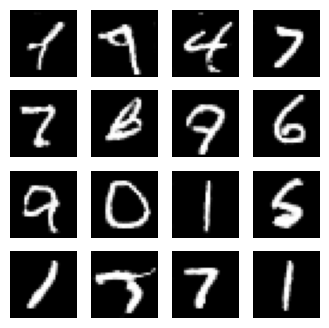

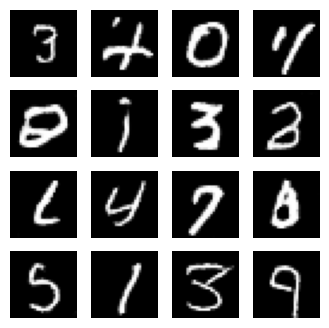

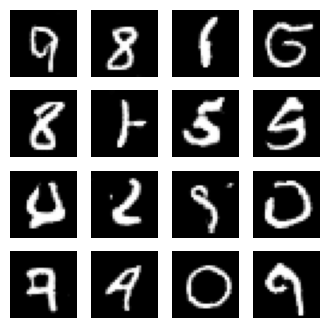

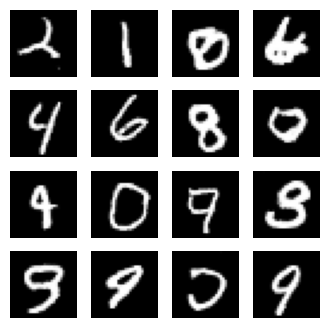

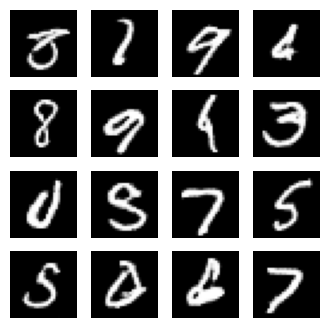

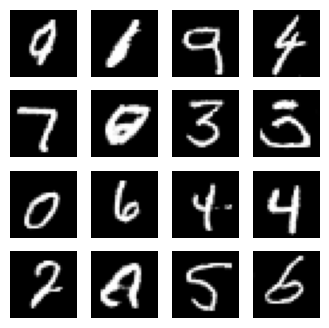

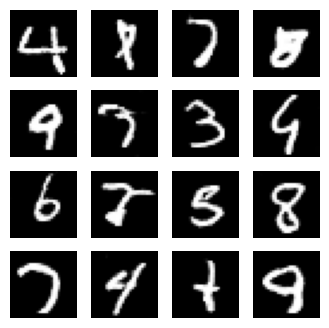

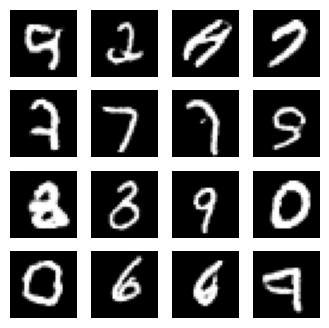

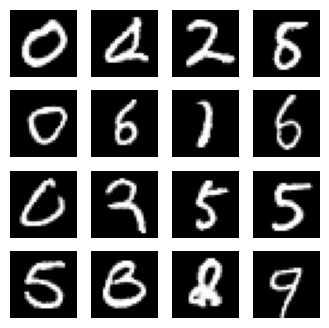

In [20]:
for epoch in range(EPOCHS):
    for i, (imgs, _) in enumerate(train_loader):
       
        # 실제 이미지와 가짜 이미지에 대한 레이블 생성
        real_labels = torch.ones(imgs.size(0), 1).to(DEVICE)
        fake_labels = torch.zeros(imgs.size(0), 1).to(DEVICE)
       
        # 실제 이미지를 장치(GPU/CPU)로 이동
        real_imgs = imgs.to(DEVICE)
       
        # ---------------------
        #  생성자(Generator) 학습
        # ---------------------
        optimizer_G.zero_grad()
       
        # 노이즈를 샘플링하여 가짜 이미지 생성
        z = torch.randn(imgs.size(0), LATENT_DIM).to(DEVICE)
        generated_imgs = generator(z)
       
        # 생성자 손실 계산 (판별자를 속이도록)
        g_loss = adversarial_loss(discriminator(generated_imgs), real_labels)
       
        # 생성자 역전파 및 가중치 업데이트
        g_loss.backward()
        optimizer_G.step()
       
        # ---------------------
        #  판별자(Discriminator) 학습
        # ---------------------
        optimizer_D.zero_grad()
       
        # 실제 이미지에 대한 손실 계산
        real_loss = adversarial_loss(discriminator(real_imgs), real_labels)
       
        # 가짜 이미지에 대한 손실 계산
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake_labels)
        # .detach()를 사용하여 생성자의 그래디언트가 판별자 학습에 영향을 주지 않도록 함
       
        d_loss = (real_loss + fake_loss) / 2
       
        # 판별자 역전파 및 가중치 업데이트
        d_loss.backward()
        optimizer_D.step()


    # 에포크 종료 후 로그 출력
    print(f"[Epoch {epoch}/{EPOCHS}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
    view_images(epoch, generator, LATENT_DIM, DEVICE)